<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 24hr predictions

Clean version

1. Batch data.
2. Data_columns - Test_data_columns
3. For bulk data, fill missing data with 0.
4. Add columns to indicate missing genes and fill missing gene with 0.
  - Add data augmentation that does this on training data.
  - For some reason, data augmentation performed worse.
5. Use linear layer for 24hr prediction.
  - Trying on other bulk data.
6. Modified R2 score
5. Gene normalization

TODO:
  - Reduce the bulk into smaller.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

/home/galopy/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/'Colab Notebooks'
# !pip -q install torcheval
# !pip -q install datasets
# path = Path('data/circadian')
path = Path('data')

In [3]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

import fastcore.all as fc

In [4]:
loss_func = F.mse_loss

In [5]:
class TimeLayer(nn.Module):
    def __init__(self, range = 26):
        super().__init__()
        self.range = range

    def forward(self, x):
        # return (F.sigmoid(x) * self.range - (self.range - 24)/2) % 24
        return (F.sigmoid(x) * self.range - (self.range - 24)/2)

In [6]:
from torcheval.metrics import R2Score
# metric = MetricsCB(R2Score=R2Score())
# metric = R2Score()

In [7]:
class TimeR2Score(R2Score):
    def update(self, input, target):
        inp = input.clone()
        for i, (x, y) in enumerate(zip(input, target)):
            min_x = x
            min_diff = torch.inf
            for z in [x-24, x, x+24]:
                if abs(z-y) < min_diff:
                    min_diff = abs(z-y)
                    min_x = z
            inp[i] = min_x
        super().update(inp, target)

In [8]:
metric = MetricsCB(R2Score=TimeR2Score())

## Data

In [11]:
meta_data = pd.read_csv(path/'meta_data.csv', low_memory=False)
raw_data = pd.read_csv(path/'RNA_count_mat.csv', low_memory=False)

In [12]:
data = raw_data.set_index('gene').T
cell_sums = data.sum(axis=1)
cell_divided = data.div(cell_sums, axis=0)
nrm = (cell_divided - cell_divided.mean(axis=0)) / cell_divided.std(axis=0)
data = nrm
df_mis = pd.DataFrame({f'{col}_missing':np.zeros(data.shape[0], dtype=int) for col in data.columns}, index=data.index)
data2 = data.join(df_mis)
df = data2.join(meta_data.set_index('cell_name'))
df['code'] = df.loc[:,'ZT'].str[-2:].map(float)

In [14]:
# batch_ct = pd.read_csv(batch_path/'sc_RNA_ct.csv', low_memory=False)
# batch_zt = pd.read_csv(batch_path/'sc_RNA_ZT.csv', low_memory=False)
# batch_ct.head()

In [26]:
# batch_zt.head()

,Unnamed: 0,ZT
0,AAACAGCCAGCAATAA-8,ZT18
1,AAACGCGCAGTATGTT-8,ZT18
2,AAAGCGGGTGCATCGG-8,ZT18
3,AAAGGACGTAAGGTTT-8,ZT18
4,AAAGGAGCAACCGCCA-8,ZT18


In [15]:
# batch_zt

### Bulk + scRNA-seq

In [16]:
raw_gro = pd.read_csv(path/'gro.csv', low_memory=False)
raw_gro.drop(columns=['Unnamed: 0'], inplace=True)
raw_gro.rename(columns={'Symbol': 'ID'}, inplace=True)

In [17]:
raw_nascent = pd.read_csv(path/'Nascent.csv', low_memory=False)
raw_nascent.drop(columns=['Unnamed: 0'], inplace=True)

In [18]:
raw_bulk_data = pd.read_csv(path/'RNA.csv', low_memory=False)

In [19]:
bulk_data = raw_bulk_data.set_index('ID').T
bulk_data = (bulk_data - bulk_data.mean(axis=0)) / bulk_data.std(axis=0)
bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]

In [20]:
bulk_data.head()

ID,2810459M11Rik,Abcb11,Acot7,Ahctf1,Ap2a2,Asb13,Asl,Chka,Clic3,Clpx,...,Ap1s3,Vamp4,Pigm,Pard6g,Gas2,Pot1b,Zfp759,Neo1,Sco1,code
ZT2_1,1.105385,1.734929,-1.000468,-0.675204,0.840018,0.483757,-1.549016,0.124098,-0.232362,0.848045,...,2.752890,-0.473227,1.929628,0.128575,-0.790649,-0.444183,0.143286,-0.561441,-0.562906,2
ZT6_1,0.140685,0.362813,0.216831,-1.176028,-0.819429,-0.259607,-0.637751,-1.136919,-0.522711,-1.026734,...,-0.789960,0.250906,-0.690604,0.128575,0.738327,-1.036427,-1.197874,1.199442,0.094325,6
ZT10_1,-0.816706,-1.059483,0.376602,-0.640493,-1.968277,-1.844144,0.759326,-1.019758,-0.540232,-1.165550,...,0.215444,0.250906,-0.243742,-1.651693,-0.302307,-0.049354,1.828333,-1.939524,-1.767828,10
ZT14_1,-0.746059,-0.951535,1.700414,0.762807,-0.123532,-0.425885,0.793645,-0.165720,-0.294937,-0.431148,...,0.550578,1.622947,0.487485,0.959366,0.023254,-0.049354,-0.647654,1.429123,1.372273,14
ZT18_1,0.250310,-0.396195,0.361386,1.328094,0.432362,0.625583,0.991523,0.580407,0.012932,1.159798,...,-0.406949,-1.197360,0.934346,-0.108794,1.197601,0.740305,0.074509,-0.178640,0.422940,18


In [21]:
gro = raw_gro.set_index('ID').T
nascent = raw_nascent.set_index('ID').T
gro = (gro - gro.mean(axis=0)) / gro.std(axis=0)
nascent = (nascent - nascent.mean(axis=0)) / nascent.std(axis=0)

bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]
gro['code'] = [1,4,7,10,13,16,19,22]
nascent['code'] = [0,4,8,12,16,20,0,4,8,12,16,20]

In [22]:
bulk_genes_set = set(raw_bulk_data['ID'])
sc_genes = raw_data['gene']

In [23]:
genes = [gene for gene in sc_genes if gene in bulk_genes_set]

In [24]:
mis_genes = [gene for gene in sc_genes if gene not in bulk_genes_set]

`df2` is the bulk data used for testing.

In [25]:
df2 = pd.DataFrame(np.zeros((12, 6000), dtype=int), columns=data2.columns)

In [26]:
for gene in genes:
    df2[gene] = bulk_data[gene].values

In [27]:
for gene in sc_genes:
    if gene not in bulk_genes_set:
        df2[f'{gene}_missing'] = 1

In [28]:
df2['code'] = bulk_data['code'].values.astype(float)

/tmp/ipykernel_6827/1075454734.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2['code'] = bulk_data['code'].values.astype(float)


In [29]:
def make_df(dataset):
    genes_set = set(dataset.columns[:-1])
    genes = [gene for gene in sc_genes if gene in genes_set]
    mis_genes = [gene for gene in sc_genes if gene not in genes_set]
    df = pd.DataFrame(np.zeros((dataset.shape[0], 6000), dtype=int), columns=data2.columns)
    for gene in genes:
        df[gene] = dataset[gene].values
    for gene in sc_genes:
        if gene not in genes_set:
            df[f'{gene}_missing'] = 1
    df['code'] = dataset['code'].values.astype(float)
    print(f'% missing: {len(mis_genes)/3000*100}%')
    return df

In [30]:
nascent_df = make_df(nascent)
gro_df = make_df(gro)
rna_df = make_df(bulk_data)

/tmp/ipykernel_6827/731159244.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)
/tmp/ipykernel_6827/731159244.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 47.56666666666667%
% missing: 47.56666666666667%
% missing: 47.56666666666667%


/tmp/ipykernel_6827/731159244.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


## Using Pytorch

In [31]:
t_dep = tensor(df['code'], dtype=torch.float)
indep_cols = list(df.columns)[:-2]
t_indep = tensor(df[indep_cols].values, dtype=torch.float32)

/tmp/ipykernel_6827/3413784403.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_dep = tensor(df['code'], dtype=torch.float)


In [32]:
# from fastai.data.transforms import RandomSplitter
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
trn_split,val_split=RandomSplitter(seed=42)(df)

In [33]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [34]:
trn_dep.unsqueeze_(-1), val_dep.unsqueeze_(-1)
trn_dep.shape, val_dep.shape

(torch.Size([12794, 1]), torch.Size([3198, 1]))

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [35]:
bs = 128
n_workers = 2

trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=bs, shuffle=True, num_workers=n_workers)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=bs, shuffle=False, num_workers=n_workers)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([128, 6000]), torch.Size([128, 1]))

In [36]:
def make_dl(df):
    tst_dep = tensor(df['code'], dtype=torch.float)
    tst_indep_cols = list(df.columns)[:-1]
    tst_indep = tensor(df[tst_indep_cols].values, dtype=torch.float32)
    tst_dep.unsqueeze_(-1)
    return DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False, num_workers=n_workers)

In [37]:
nascent_dl = make_dl(nascent_df)
gro_dl = make_dl(gro_df)
rna_dl = make_dl(rna_df)
tst_dls = {'nascent':nascent_dl, 'gro':gro_dl, 'rna':rna_dl}

Changing the metric to R2Score.

In [38]:
from torcheval.metrics import R2Score
metrics = MetricsCB(TimeR2Score=TimeR2Score())
metric_fn = TimeR2Score
# metrics = MetricsCB(R2Score=R2Score())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

## Training

In [39]:
def get_model():
    return nn.Sequential(*[nn.Linear(len(indep_cols), 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 1), nn.Flatten(), TimeLayer()])

Change the shape of the inputs to match the shape of targets.

In [40]:
nn.Linear(len(indep_cols), 1)(xb).shape

torch.Size([128, 1])

In [41]:
get_model()(xb).shape

torch.Size([128, 1])

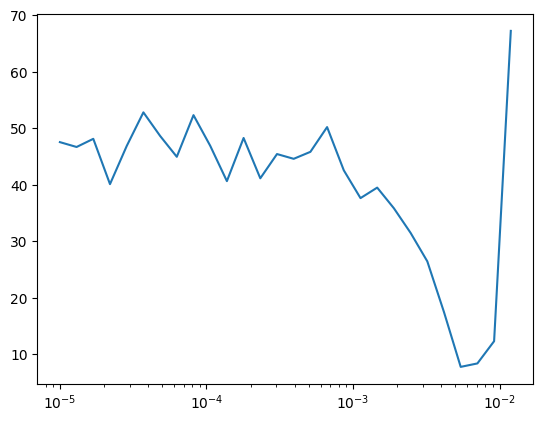

In [42]:
TrainLearner(get_model(), dls, loss_func=loss_func, cbs=cbs).lr_find()

TimeR2Score,loss,epoch,train,time
0.844,7.316,0,True,00:00
0.964,1.675,0,False,00:00
0.980,0.920,1,True,00:00
0.969,1.442,1,False,00:00


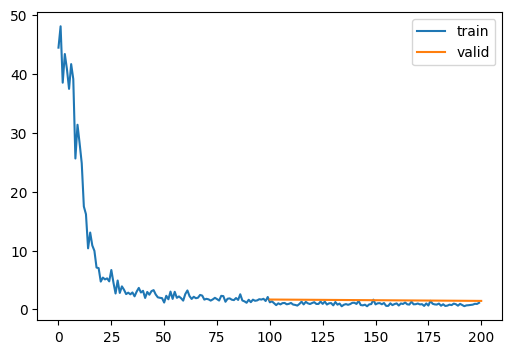

In [43]:
lr, epochs = 1e-3, 2
xtra = [get_sched(epochs, lr, dls)]
learn = TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs)
learn.fit(epochs)

## Ensemble

In [44]:
from functools import partial

In [45]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

In [46]:
def ensemble_model(nlearn, get_model = get_model, tst_dls=tst_dls, epochs=5, lr=.03, loss_func=loss_func, cbs=cbs, opt_func=optim.SGD, metric_fn=metric_fn):
    learners = [TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs, opt_func=opt_func) for _ in range(nlearn)]
    print('Training models')
    for learn in learners:
        learn.fit(epochs)
    cps = [CapturePreds() for _ in range(nlearn)]
    print('Making inference on test data')
    for dl_name, tst_dl in tst_dls.items():
        for learn, cp in zip(learners, cps):
            learn.dls = DataLoaders((), tst_dl)
            learn.fit(1, train=False, cbs=cp)
        ap = torch.stack([cp.all_preds for cp in cps]).mean(0)
        metric = metric_fn()
        metric.update(ap, cps[0].all_targs)
        print(f'Inference on {dl_name}')
        print('\t\tpreds, targs')
        print(torch.concat([ap, cps[0].all_targs], dim=1))
        print('result: ', metric.compute())

In [47]:
nlearn = 2

Training models


TimeR2Score,loss,epoch,train,time
0.824,8.239,0,True,00:00
0.965,1.616,0,False,00:00
0.979,0.986,1,True,00:00
0.970,1.386,1,False,00:00


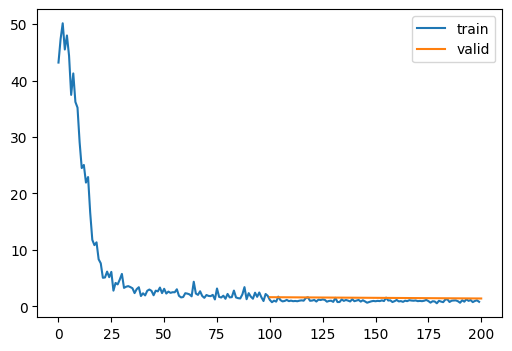

TimeR2Score,loss,epoch,train,time
0.826,8.182,0,True,00:00
0.966,1.648,0,False,00:00
0.980,0.928,1,True,00:00
0.970,1.429,1,False,00:00


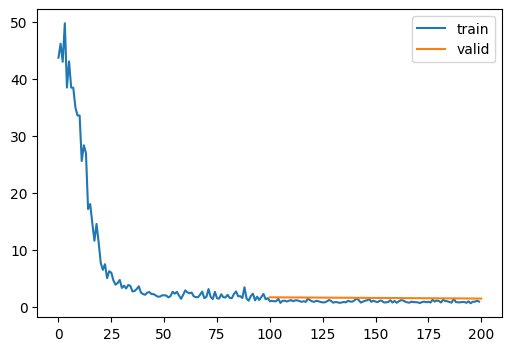

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.754,11.494,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.710,13.556,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 4.9890,  0.0000],
        [ 6.0666,  4.0000],
        [ 9.8263,  8.0000],
        [10.8710, 12.0000],
        [13.4576, 16.0000],
        [19.4136, 20.0000],
        [ 8.5340,  0.0000],
        [ 2.5354,  4.0000],
        [11.5608,  8.0000],
        [10.5335, 12.0000],
        [19.7833, 16.0000],
        [21.9432, 20.0000]])
result:  tensor(0.7349)


TimeR2Score,loss,epoch,train,time
0.619,18.003,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.700,14.181,0,False,00:00


Inference on gro
		preds, targs
tensor([[11.6871,  1.0000],
        [ 4.2073,  4.0000],
        [ 8.9618,  7.0000],
        [10.0401, 10.0000],
        [13.3782, 13.0000],
        [14.0859, 16.0000],
        [18.9493, 19.0000],
        [19.6154, 22.0000]])
result:  tensor(0.6624)


TimeR2Score,loss,epoch,train,time
0.702,13.886,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.759,11.253,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 4.9640,  2.0000],
        [ 9.6432,  6.0000],
        [ 9.2111, 10.0000],
        [12.7288, 14.0000],
        [19.3398, 18.0000],
        [20.7746, 22.0000],
        [ 6.9753,  2.0000],
        [ 9.3815,  6.0000],
        [10.9146, 10.0000],
        [12.6055, 14.0000],
        [19.1975, 18.0000],
        [12.9757, 22.0000]])
result:  tensor(0.7332)


In [48]:
ensemble_model(nlearn, epochs=2, cbs=cbs, lr=1e-3, loss_func=loss_func)

In [49]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

## Batchnorm

In [50]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(len(indep_cols), 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 1),
    nn.BatchNorm1d(1),
    TimeLayer()
]).apply(init_params)

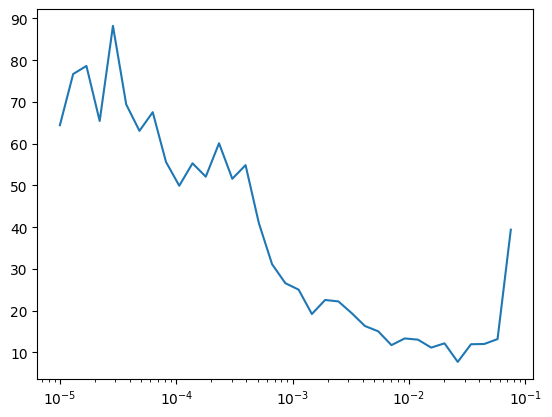

In [51]:
TrainLearner(get_model(), dls, loss_func, cbs=DeviceCB()).lr_find()

Training models


TimeR2Score,loss,epoch,train,time
0.896,5.469,0,True,00:00
0.932,4.007,0,False,00:00
0.942,2.887,1,True,00:00
0.955,2.436,1,False,00:00
0.962,1.831,2,True,00:00
0.971,1.640,2,False,00:00
0.975,1.163,3,True,00:00
0.977,1.239,3,False,00:00


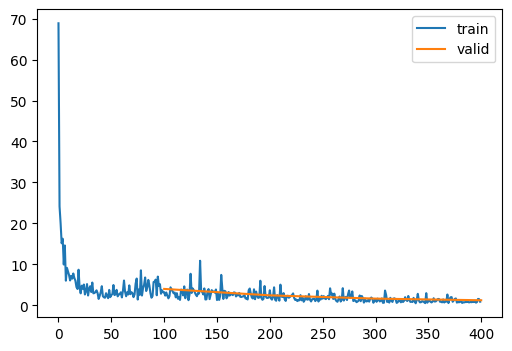

TimeR2Score,loss,epoch,train,time
0.893,5.529,0,True,00:00
0.919,4.512,0,False,00:00
0.939,3.069,1,True,00:00
0.965,1.715,1,False,00:00
0.963,1.727,2,True,00:00
0.978,1.068,2,False,00:00
0.978,1.040,3,True,00:00
0.980,1.023,3,False,00:00


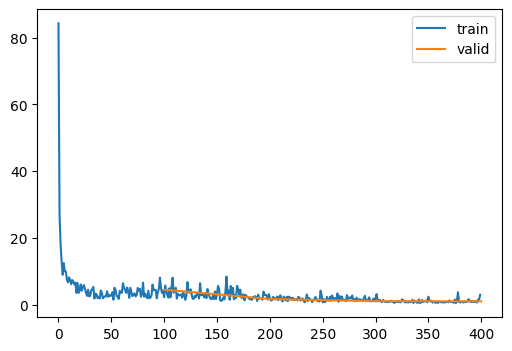

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.699,14.028,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.862,6.423,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 3.1230,  0.0000],
        [ 5.5017,  4.0000],
        [ 7.4216,  8.0000],
        [10.2111, 12.0000],
        [13.8000, 16.0000],
        [18.4568, 20.0000],
        [ 7.7119,  0.0000],
        [ 2.3535,  4.0000],
        [10.9882,  8.0000],
        [10.3857, 12.0000],
        [20.5438, 16.0000],
        [20.1417, 20.0000]])
result:  tensor(0.7908)


TimeR2Score,loss,epoch,train,time
0.782,31.187,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.804,34.605,0,False,00:00


Inference on gro
		preds, targs
tensor([[16.8529,  1.0000],
        [ 5.5769,  4.0000],
        [ 7.3979,  7.0000],
        [ 9.3720, 10.0000],
        [13.4686, 13.0000],
        [14.5502, 16.0000],
        [18.2078, 19.0000],
        [19.8162, 22.0000]])
result:  tensor(0.7959)


TimeR2Score,loss,epoch,train,time
0.777,10.395,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.879,5.644,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 1.9219,  2.0000],
        [ 7.9208,  6.0000],
        [ 9.3423, 10.0000],
        [14.4755, 14.0000],
        [19.5713, 18.0000],
        [20.7306, 22.0000],
        [ 3.7587,  2.0000],
        [ 7.8881,  6.0000],
        [10.3263, 10.0000],
        [11.3326, 14.0000],
        [19.9480, 18.0000],
        [13.8258, 22.0000]])
result:  tensor(0.8341)


In [52]:
lr, epochs = .2, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.897,5.174,0,True,00:00
0.953,2.359,0,False,00:00
0.950,2.489,1,True,00:00
0.971,1.665,1,False,00:00
0.970,1.424,2,True,00:00
0.978,1.092,2,False,00:00
0.978,1.012,3,True,00:01
0.975,1.204,3,False,00:00


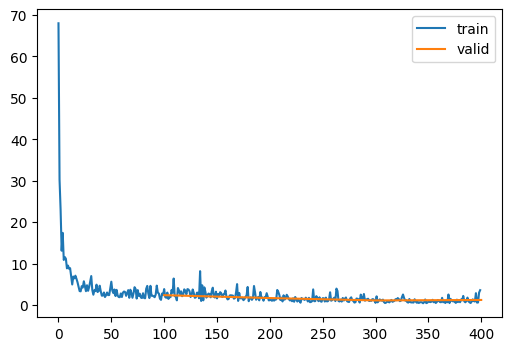

TimeR2Score,loss,epoch,train,time
0.893,5.488,0,True,00:01
0.951,2.836,0,False,00:00
0.946,2.701,1,True,00:01
0.971,1.631,1,False,00:00
0.968,1.508,2,True,00:01
0.976,1.189,2,False,00:00
0.979,0.992,3,True,00:01
0.977,1.156,3,False,00:00


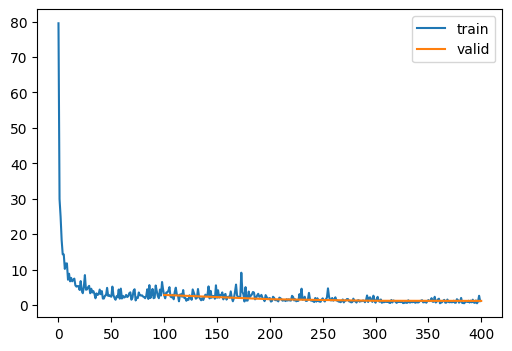

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.862,6.437,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.824,8.219,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.2817,  0.0000],
        [ 5.3572,  4.0000],
        [ 6.9603,  8.0000],
        [ 9.6922, 12.0000],
        [13.4355, 16.0000],
        [18.3131, 20.0000],
        [ 6.4276,  0.0000],
        [ 2.0961,  4.0000],
        [10.7217,  8.0000],
        [10.3851, 12.0000],
        [18.9594, 16.0000],
        [19.9736, 20.0000]])
result:  tensor(0.8454)


TimeR2Score,loss,epoch,train,time
0.787,10.061,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.658,24.163,0,False,00:00


Inference on gro
		preds, targs
tensor([[11.6055,  1.0000],
        [ 4.1493,  4.0000],
        [ 7.3212,  7.0000],
        [ 9.4764, 10.0000],
        [13.6997, 13.0000],
        [13.1188, 16.0000],
        [18.4583, 19.0000],
        [19.2868, 22.0000]])
result:  tensor(0.6579)


TimeR2Score,loss,epoch,train,time
0.728,18.728,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.858,6.641,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 1.8263,  2.0000],
        [ 6.5862,  6.0000],
        [ 9.2123, 10.0000],
        [14.1095, 14.0000],
        [18.4773, 18.0000],
        [20.6268, 22.0000],
        [ 4.8911,  2.0000],
        [ 6.4863,  6.0000],
        [ 9.9565, 10.0000],
        [11.3565, 14.0000],
        [19.5529, 18.0000],
        [11.1005, 22.0000]])
result:  tensor(0.7502)


In [53]:
lr, epochs = .1, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.898,5.343,0,True,00:01
0.903,4.918,0,False,00:00
0.928,3.627,1,True,00:01
0.951,2.540,1,False,00:00
0.951,2.449,2,True,00:01
0.967,1.785,2,False,00:00
0.972,1.299,3,True,00:01
0.978,1.110,3,False,00:00
0.979,1.006,4,True,00:01
0.980,1.041,4,False,00:00


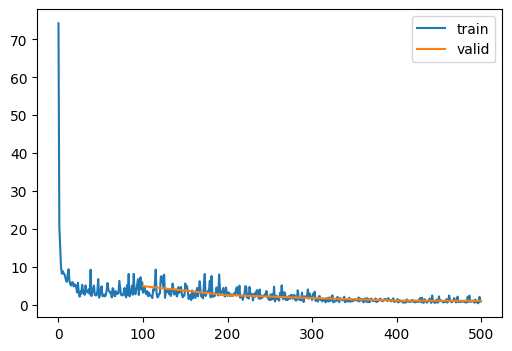

TimeR2Score,loss,epoch,train,time
0.900,5.097,0,True,00:01
0.915,4.300,0,False,00:00
0.932,3.427,1,True,00:01
0.952,2.420,1,False,00:00
0.953,2.298,2,True,00:01
0.972,1.590,2,False,00:00
0.968,1.520,3,True,00:01
0.975,1.264,3,False,00:00
0.980,0.925,4,True,00:01
0.979,1.040,4,False,00:00


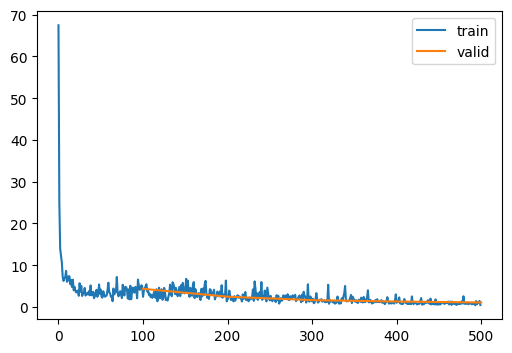

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.851,6.944,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.835,7.698,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.6834,  0.0000],
        [ 6.0738,  4.0000],
        [ 7.2856,  8.0000],
        [10.0693, 12.0000],
        [13.7955, 16.0000],
        [18.2044, 20.0000],
        [ 5.8143,  0.0000],
        [ 3.2176,  4.0000],
        [10.4120,  8.0000],
        [10.4078, 12.0000],
        [20.4636, 16.0000],
        [19.9389, 20.0000]])
result:  tensor(0.8455)


TimeR2Score,loss,epoch,train,time
0.802,9.338,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.690,14.670,0,False,00:00


Inference on gro
		preds, targs
tensor([[10.0487,  1.0000],
        [ 5.5612,  4.0000],
        [ 7.8439,  7.0000],
        [ 9.4399, 10.0000],
        [13.8791, 13.0000],
        [15.1373, 16.0000],
        [18.6381, 19.0000],
        [19.3659, 22.0000]])
result:  tensor(0.7515)


TimeR2Score,loss,epoch,train,time
0.826,8.129,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.935,3.036,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 3.1733,  2.0000],
        [ 7.0262,  6.0000],
        [ 9.5979, 10.0000],
        [13.9723, 14.0000],
        [19.3479, 18.0000],
        [21.4075, 22.0000],
        [ 3.8911,  2.0000],
        [ 6.7691,  6.0000],
        [10.3441, 10.0000],
        [11.2929, 14.0000],
        [19.2739, 18.0000],
        [15.5552, 22.0000]])
result:  tensor(0.8937)


In [54]:
lr, epochs = .3, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.893,5.410,0,True,00:01
0.968,1.627,0,False,00:00
0.951,2.468,1,True,00:01
0.961,2.322,1,False,00:00
0.965,1.648,2,True,00:01
0.970,1.676,2,False,00:00
0.974,1.225,3,True,00:01
0.983,0.939,3,False,00:00
0.982,0.868,4,True,00:01
0.985,0.793,4,False,00:00


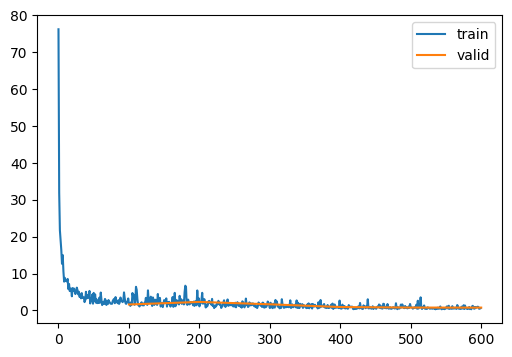

TimeR2Score,loss,epoch,train,time
0.885,5.877,0,True,00:01
0.956,2.118,0,False,00:00
0.949,2.628,1,True,00:01
0.954,2.432,1,False,00:00
0.958,2.018,2,True,00:01
0.970,1.628,2,False,00:00
0.973,1.280,3,True,00:01
0.976,1.209,3,False,00:00
0.980,0.942,4,True,00:01
0.982,0.939,4,False,00:00


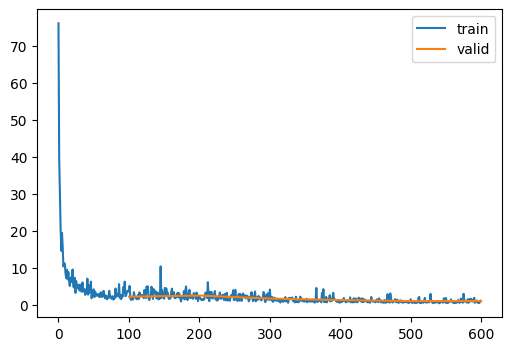

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.865,6.295,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.873,5.931,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.1770,  0.0000],
        [ 5.7517,  4.0000],
        [ 6.9831,  8.0000],
        [ 9.9849, 12.0000],
        [13.8769, 16.0000],
        [18.2976, 20.0000],
        [ 5.0311,  0.0000],
        [ 2.4554,  4.0000],
        [10.6702,  8.0000],
        [10.4679, 12.0000],
        [19.8996, 16.0000],
        [20.2455, 20.0000]])
result:  tensor(0.8701)


TimeR2Score,loss,epoch,train,time
0.689,14.705,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.596,20.444,0,False,00:00


Inference on gro
		preds, targs
tensor([[12.2455,  1.0000],
        [ 4.4719,  4.0000],
        [ 7.0442,  7.0000],
        [ 9.5608, 10.0000],
        [13.7972, 13.0000],
        [13.8468, 16.0000],
        [18.8050, 19.0000],
        [19.2948, 22.0000]])
result:  tensor(0.6309)


TimeR2Score,loss,epoch,train,time
0.879,5.640,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.856,6.709,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 1.7405,  2.0000],
        [ 7.4752,  6.0000],
        [ 9.5034, 10.0000],
        [13.9134, 14.0000],
        [19.0897, 18.0000],
        [20.4112, 22.0000],
        [ 2.5638,  2.0000],
        [ 7.2958,  6.0000],
        [10.0923, 10.0000],
        [11.0618, 14.0000],
        [19.4999, 18.0000],
        [14.7090, 22.0000]])
result:  tensor(0.8710)


In [55]:
lr, epochs = .1, 6
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Conclusion

Unfortunately, deeper network did not perform better on bulk data than shallower network even if they did better on scRNA-seq data. Maybe because the training data is too noisy with random numbers.